In [1]:
# !pip install pandas numpy scikit-learn transformers
import pandas as pd
import numpy as np
from tqdm.notebook import tqdm

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt

import re
import torch

from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertTokenizer, BertModel

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
job_df = pd.read_parquet('/kaggle/input/job-offers/reed_uk_data.parquet')[['job_title', 'job_description']].sample(1000)
resume_df = pd.read_csv('/kaggle/input/resumecorpus-cleaned/finale.csv')[['Label', 'Text']].sample(1000)

print(f"job data shape: {job_df.shape}, resume: {resume_df.shape}")

job data shape: (1000, 2), resume: (1000, 2)


In [3]:
job_df.sample(3)

,job_title,job_description
14093,Infrastructure Civil Operative,Apply now Our in-house maintenance team work ...
18498,Primary Teacher - Year 2,Apply now Primary Teacher - Year 2Year 2 prim...
39281,Front of House Receptionist - Interiors Showroom,Apply now An exciting Front of House role exi...


In [4]:
resume_df.sample(3)

,Label,Text
17337,[],Network ContractorOnsite Administrator SANetwo...
18147,"[b'Python_Developer\n', b'Software_Developer']",Sr Python DeveloperSr Python DeveloperPython D...
10530,[b'Security_Analyst'],Senior IT Risk Specialist ConsultantInformatio...


In [5]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
import subprocess
import torch.nn as nn

In [6]:
# Download and unzip wordnet
try:
    nltk.data.find('wordnet.zip')
    nltk.data.find('stopwords.zip')
    nltk.data.find('punkt.zip')
except:
    nltk.download('punkt', download_dir='/kaggle/working/')
    nltk.download('stopwords', download_dir='/kaggle/working/')
    nltk.download('wordnet', download_dir='/kaggle/working/')
    
    command = "unzip /kaggle/working/corpora/punkt.zip -d /kaggle/working/corpora"
    command = "unzip /kaggle/working/corpora/stopwords.zip -d /kaggle/working/corpora"
    command = "unzip /kaggle/working/corpora/wordnet.zip -d /kaggle/working/corpora"

    subprocess.run(command.split())
    nltk.data.path.append('/kaggle/working/')

# Now you can import the NLTK resources as usual
from nltk.corpus import wordnet, stopwords

[nltk_data] Downloading package punkt to /kaggle/working/...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /kaggle/working/...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /kaggle/working/...
Archive:  /kaggle/working/corpora/wordnet.zip
   creating: /kaggle/working/corpora/wordnet/
  inflating: /kaggle/working/corpora/wordnet/lexnames  
  inflating: /kaggle/working/corpora/wordnet/data.verb  
  inflating: /kaggle/working/corpora/wordnet/index.adv  
  inflating: /kaggle/working/corpora/wordnet/adv.exc  
  inflating: /kaggle/working/corpora/wordnet/index.verb  
  inflating: /kaggle/working/corpora/wordnet/cntlist.rev  
  inflating: /kaggle/working/corpora/wordnet/data.adj  
  inflating: /kaggle/working/corpora/wordnet/index.adj  
  inflating: /kaggle/working/corpora/wordnet/LICENSE  
  inflating: /kaggle/working/corpora/wordnet/citation.bib  
  inflating: /kaggle/working/corpora/wordnet/noun.exc  


In [7]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess_text(text):
    # remove special characters and digits
    text = re.sub(r'\W+', ' ', text.lower())
    # tokenize the text
    tokens = word_tokenize(text)
    # remove stop words and perform lemmatization
    tokens = [lemmatizer.lemmatize(token) for token in tokens if token not in stop_words]
    # rejoin the tokens into a string
    clean_text = ' '.join(tokens)
    return clean_text

job_df['clean_description'] = list(tqdm(job_df['job_description'].apply(preprocess_text), desc='cleaning offers desc'))
resume_df['clean_content'] = list(tqdm(resume_df['Text'].apply(preprocess_text), desc='cleaning resume cont'))

cleaning offers desc:   0%|          | 0/1000 [00:00<?, ?it/s]

cleaning resume cont:   0%|          | 0/1000 [00:00<?, ?it/s]

In [9]:
job_df['clean_description'].iloc[0]

'apply client looking recruit carpenter joiner immediate start work alongside friendly hard working team main duty include prepare drawing cabinetry framing construction project siteinterpret client request provide mock ups client approve prior commencing workbuild cabinet vanity tub shower surround project based demandframe room addition needed clientselect evaluate material defectsinstall cabinet counter mouldingfollow code requirement kitchen bath remoulding project hour work may vary candidate must flexible candidate must time served hold relevant certification general knowledge area joinery production would beneficial role working site busy workshop'

In [11]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
text = job_df['clean_description'].iloc[0]
print(nltk.word_tokenize(text))

['apply', 'client', 'looking', 'recruit', 'carpenter', 'joiner', 'immediate', 'start', 'work', 'alongside', 'friendly', 'hard', 'working', 'team', 'main', 'duty', 'include', 'prepare', 'drawing', 'cabinetry', 'framing', 'construction', 'project', 'siteinterpret', 'client', 'request', 'provide', 'mock', 'ups', 'client', 'approve', 'prior', 'commencing', 'workbuild', 'cabinet', 'vanity', 'tub', 'shower', 'surround', 'project', 'based', 'demandframe', 'room', 'addition', 'needed', 'clientselect', 'evaluate', 'material', 'defectsinstall', 'cabinet', 'counter', 'mouldingfollow', 'code', 'requirement', 'kitchen', 'bath', 'remoulding', 'project', 'hour', 'work', 'may', 'vary', 'candidate', 'must', 'flexible', 'candidate', 'must', 'time', 'served', 'hold', 'relevant', 'certification', 'general', 'knowledge', 'area', 'joinery', 'production', 'would', 'beneficial', 'role', 'working', 'site', 'busy', 'workshop']


In [12]:
from transformers import logging

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertModel.from_pretrained('bert-base-uncased')
adaptive_pool = nn.AdaptiveAvgPool1d(1024)

# To set the verbosity level to error
logging.set_verbosity_error()

def encode_text(text):
    input_ids = torch.tensor(tokenizer.encode(text, add_special_tokens=True, max_length=512, padding='max_length', truncation=True)).unsqueeze(0)
    outputs = model(input_ids)
    last_hidden_state = outputs[0].squeeze(0)
    
    # Apply Adaptive Average Pooling
    last_hidden_state_pooled = adaptive_pool(last_hidden_state.permute(1, 0)).permute(1, 0)
    
    mean_pooling = torch.mean(last_hidden_state_pooled, dim=0)
    return mean_pooling.detach().numpy()


job_df['bert_embedding'] = list(tqdm(job_df['job_description'].apply(encode_text), desc='encoding offers desc'))
resume_df['bert_embedding'] = list(tqdm(resume_df['Text'].apply(encode_text), desc='encoding resume cont'))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


encoding offers desc:   0%|          | 0/1000 [00:00<?, ?it/s]

encoding resume cont:   0%|          | 0/1000 [00:00<?, ?it/s]

In [13]:
job_embeddings = np.stack(job_df['bert_embedding'].to_numpy())
resume_embeddings = np.stack(resume_df['bert_embedding'].to_numpy())

similarity_matrix = cosine_similarity(job_embeddings, resume_embeddings)

In [14]:
similarity_matrix

array([[0.9468733 , 0.4487933 , 0.48842493, ..., 0.7420622 , 0.5213874 ,
        0.50609225],
       [0.8264208 , 0.6568023 , 0.6590417 , ..., 0.8534813 , 0.6722827 ,
        0.65899134],
       [0.8348832 , 0.6280403 , 0.6413124 , ..., 0.83162403, 0.6559186 ,
        0.6434086 ],
       ...,
       [0.5496036 , 0.72949827, 0.71510184, ..., 0.76834893, 0.708872  ,
        0.70876896],
       [0.22157615, 0.69996464, 0.6640557 , ..., 0.5539521 , 0.6406559 ,
        0.644861  ],
       [0.78200144, 0.67152786, 0.6851895 , ..., 0.8192309 , 0.6875726 ,
        0.68907964]], dtype=float32)

In [15]:
def dynamic_clustering(data, max_clusters=None):
    if max_clusters is None:
        max_clusters = len(data)
    
    inertia_values = []
    num_clusters = range(1, max_clusters + 1)
    
    for k in num_clusters:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(data)
        inertia_values.append(kmeans.inertia_)
    
    # Plotting elbow curve
    plt.plot(num_clusters, inertia_values, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Plot')
    plt.show()
    
    # Choosing optimal number of clusters based on elbow plot
    optimal_clusters = input("Enter the number of clusters to use: ")
    optimal_clusters = int(optimal_clusters)
    
    # Perform clustering with optimal number of clusters
    kmeans = KMeans(n_clusters=optimal_clusters, random_state=42)
    kmeans.fit(data)
    cluster_labels = kmeans.labels_
    
    return cluster_labels

/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

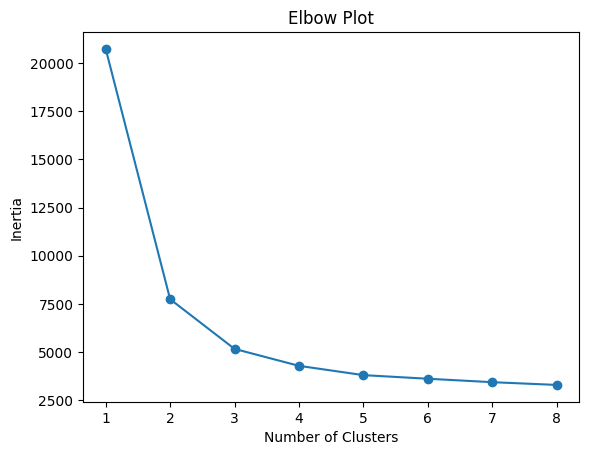

Enter the number of clusters to use:  8


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:8

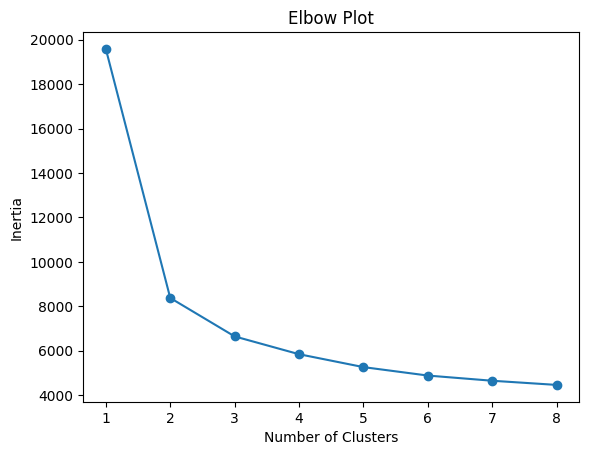

Enter the number of clusters to use:  8


/opt/conda/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [16]:
job_clusters = dynamic_clustering(job_embeddings, max_clusters=8)
resume_clusters = dynamic_clustering(resume_embeddings, max_clusters=8)

In [17]:
job_clusters

array([3, 5, 5, 0, 2, 4, 4, 4, 4, 0, 5, 0, 1, 5, 4, 3, 7, 6, 1, 0, 5, 5,
       7, 3, 5, 5, 4, 6, 2, 5, 2, 1, 5, 3, 4, 4, 0, 1, 6, 3, 1, 2, 5, 3,
       5, 1, 5, 6, 0, 6, 3, 4, 7, 5, 4, 2, 2, 5, 1, 4, 5, 7, 5, 4, 4, 2,
       5, 4, 2, 1, 2, 0, 2, 4, 6, 0, 5, 2, 1, 1, 2, 1, 5, 4, 3, 3, 5, 7,
       2, 5, 0, 1, 3, 5, 6, 1, 7, 1, 3, 5, 3, 3, 5, 6, 3, 3, 3, 5, 5, 7,
       1, 4, 1, 7, 7, 0, 2, 1, 2, 2, 0, 3, 6, 6, 7, 3, 6, 5, 6, 2, 0, 1,
       2, 6, 3, 3, 7, 1, 0, 5, 6, 7, 2, 2, 1, 6, 5, 2, 0, 2, 5, 2, 5, 4,
       5, 5, 5, 1, 5, 5, 3, 5, 0, 7, 3, 2, 1, 4, 5, 6, 7, 3, 2, 4, 2, 3,
       5, 2, 4, 2, 2, 3, 0, 2, 1, 4, 1, 5, 7, 7, 4, 0, 2, 2, 6, 6, 2, 1,
       0, 3, 3, 3, 5, 0, 1, 5, 2, 2, 7, 1, 5, 5, 1, 1, 1, 0, 3, 4, 3, 6,
       3, 6, 0, 5, 3, 7, 5, 1, 5, 2, 7, 1, 0, 4, 3, 2, 5, 3, 4, 5, 1, 5,
       7, 0, 1, 2, 2, 0, 2, 5, 0, 4, 6, 2, 7, 7, 0, 2, 6, 2, 5, 0, 5, 0,
       4, 1, 0, 0, 2, 5, 1, 0, 0, 5, 5, 2, 5, 1, 7, 3, 3, 2, 1, 1, 0, 1,
       7, 6, 5, 5, 3, 1, 2, 7, 3, 1, 7, 4, 3, 3, 7,

In [18]:
resume_clusters

array([3, 4, 4, 0, 1, 1, 5, 6, 7, 0, 4, 5, 4, 4, 4, 0, 7, 1, 1, 3, 0, 6,
       7, 4, 4, 4, 4, 4, 4, 5, 6, 4, 2, 5, 6, 4, 2, 5, 7, 2, 1, 7, 7, 6,
       6, 6, 0, 4, 6, 6, 6, 2, 0, 4, 7, 6, 4, 7, 3, 4, 6, 6, 0, 6, 6, 5,
       0, 3, 5, 6, 6, 2, 6, 1, 0, 6, 2, 6, 4, 0, 3, 6, 3, 6, 1, 6, 5, 1,
       0, 1, 1, 6, 5, 2, 7, 4, 6, 6, 7, 4, 7, 6, 6, 5, 6, 3, 1, 4, 6, 6,
       4, 5, 4, 6, 6, 4, 7, 6, 4, 6, 6, 0, 5, 4, 6, 6, 6, 7, 6, 5, 1, 7,
       1, 7, 4, 7, 0, 1, 2, 3, 2, 7, 6, 5, 5, 1, 0, 4, 6, 4, 0, 6, 0, 0,
       6, 4, 0, 1, 4, 6, 1, 4, 0, 3, 1, 6, 4, 6, 6, 6, 5, 3, 6, 6, 0, 0,
       3, 7, 4, 5, 0, 3, 0, 6, 1, 6, 6, 0, 1, 1, 5, 0, 3, 2, 1, 3, 0, 7,
       4, 4, 6, 1, 6, 4, 1, 3, 6, 4, 3, 4, 1, 7, 4, 6, 3, 6, 6, 4, 4, 6,
       3, 3, 6, 1, 3, 7, 7, 2, 6, 6, 6, 4, 0, 3, 4, 6, 0, 6, 2, 3, 2, 4,
       6, 2, 6, 3, 0, 6, 6, 1, 4, 6, 4, 3, 3, 6, 1, 0, 1, 4, 4, 6, 0, 1,
       1, 2, 7, 0, 0, 4, 4, 6, 6, 2, 0, 4, 6, 0, 6, 6, 4, 2, 6, 5, 6, 7,
       4, 6, 0, 1, 0, 6, 2, 6, 2, 6, 5, 0, 4, 0, 2,

In [19]:
job_df['cluster'] = job_clusters
resume_df['cluster'] = resume_clusters

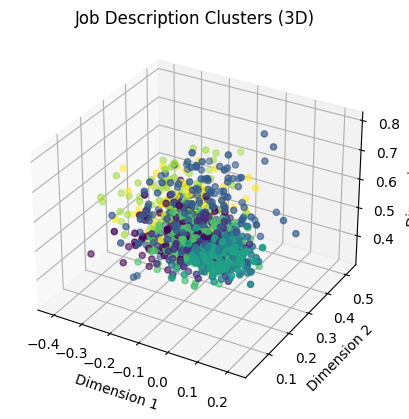

In [20]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(job_embeddings[:,0], job_embeddings[:,1], job_embeddings[:,2], c=job_clusters)
ax.set_title("Job Description Clusters (3D)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

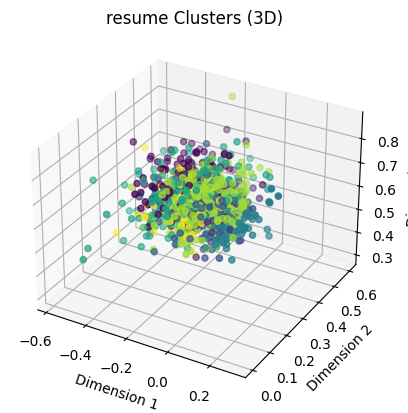

In [21]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(resume_embeddings[:,0], resume_embeddings[:,1], resume_embeddings[:,2], c=resume_clusters)
ax.set_title("resume Clusters (3D)")
ax.set_xlabel("Dimension 1")
ax.set_ylabel("Dimension 2")
ax.set_zlabel("Dimension 3")
plt.show()

In [46]:
def find_similar_resumes(job_description, resume_embeddings, resume_clusters, resume_df, top_n=2):
    # Find the cluster label of the job description
    job_cluster = job_clusters[1]

    # Calculate the cosine similarity between the job description and all the resumes in the same cluster
    resume_similarities = cosine_similarity(job_description.reshape(1, -1), resume_embeddings[resume_clusters == job_cluster])

    # Get the indices of the top N most similar resumes
    top_resume_indices = resume_similarities.argsort()[0][::-1][:top_n]

    # Print the example job description
    print("\nExample job description:\n")
    print(f"------- JOB ----------\n\n{job_df.iloc[3]['clean_description']}")

    # Print the top N most similar resumes
    print(f"\nTop {top_n} most similar resumes:")
    for i in top_resume_indices:
        print(f'\n\n------- resume ----------\n\n{resume_df.loc[resume_clusters == job_cluster].iloc[i]["clean_content"]}')

In [47]:
def find_similar_jobs(resume, job_embeddings, job_clusters, job_df, top_n=2):
    # Find the cluster label of the resume
    resume_cluster = resume_clusters[0]

    # Calculate the cosine similarity between the resume and all the job descriptions in the same cluster
    job_similarities = cosine_similarity(resume.reshape(1, -1), job_embeddings[job_clusters == resume_cluster])

    # Get the indices of the top N most similar job descriptions
    top_job_indices = job_similarities.argsort()[0][::-1][:top_n]

    # Print the example resume
    print("\nExample resume:\n")
    print(f"------- resume ----------\n\n{resume_df.iloc[420]['clean_content']}")

    # Print the top N most similar job descriptions
    print(f"\nTop {top_n} most similar job descriptions:")
    for i in top_job_indices:
        print(f'\n\n------- JOBS ----------\n\n{job_df.loc[job_clusters == resume_cluster].iloc[i]["clean_description"]}')

In [48]:
# Example usage:
query_job = job_embeddings[3]
find_similar_resumes(query_job, resume_embeddings, resume_clusters, resume_df, top_n=2)


Example job description:

------- JOB ----------

apply client looking corporate development manager join ceo team stunning london office permanent basis great opportunity join international law firm culture provides people world class support achieve ambition supporting ceo senior management corporate development manager advise strategy future development firm working sensitive issue key duty include monitoring analysing structure legal profession report potential growth expansion opportunity providing financial market data highlight pro con potential initiativesassisting decision making process regarding proposal project managing potential mergerskeeping across firmâ strategic objective managing various work stream involved firm wide projectsproviding financial operational administrative support management team proposed merger acquisition involving small large group partner team client looking bright flexible driven individual support future development firm mba qualified manager 2 

In [49]:
query_resume = resume_embeddings[420]
find_similar_jobs(query_resume, job_embeddings, job_clusters, job_df, top_n=2)


Example resume:

------- resume ----------

network engineernetwork consultantnetwork engineersystem network administratornetwork engineerbgpcatalystciscodhcpeigrpjunipermplsospfsonettacacsdsdstttcptcpipvmwarevpndnsfirewallsnetwork engineer network engineer network engineer tulsa ok ccent certified network engineer year experience network design implementation support routing switching firewall technology system design implementation troubleshooting complex network system extensive work experience cisco switch cisco router load balancer cisco firewall comprehensive expertise implementation analysis optimization troubleshooting documentation lanwan networking system handson experience upgradation cisco io different cisco device module extensive experience interpretingapplying risk management framework hand experience security vulnerability scanning supply chain risk management extensive knowledge vlans trunking rstp snmp ether channel hsrp port security acls qos traffic policing shapin